This jupyter notebook is built with these previous contributors:
1. https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d Keras Model for Beginners (0.210 on LB)+EDA+R&D by DeveshMaheshwari
2. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99 Welcome to deep learning (CNN 99%) by Peter Grenholm
3. https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ Display Deep Learning Model Training History in Keras by Jason Brownlee
4. https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/ Evaluate the Performance Of Deep Learning Models in Keras by Jason Brownlee

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from scipy.ndimage.filters import median_filter
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

# data processing

### Import the data

In [2]:
#Load the data.
train = pd.read_json("train.json")
test = pd.read_json("test.json")

In [3]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

(1604, 75, 75)

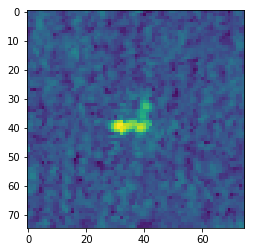

In [5]:
plt.imshow(X_band_1[1])
X_band_1.shape

In [6]:
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=-1)

### Rotate the image 90, 180 degrees 

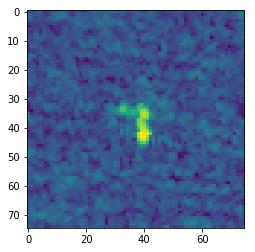

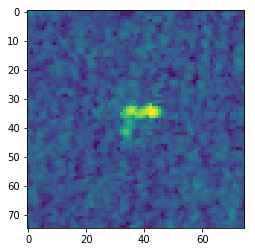

In [7]:
X_band_1_rotate90 = np.array([np.rot90(image) for image in X_band_1])
X_band_2_rotate90 = np.array([np.rot90(image) for image in X_band_2])
plt.imshow(X_band_1_rotate90[1])

X_band_1_rotate180 = np.array([np.rot90(image,2) for image in X_band_1])
X_band_2_rotate180 = np.array([np.rot90(image,2) for image in X_band_2])
plt.figure()
plt.imshow(X_band_1_rotate180[1])

In [8]:
X_train_rotate90 = np.concatenate([X_band_1_rotate90[:, :, :, np.newaxis], X_band_2_rotate90[:, :, :, np.newaxis]], axis=-1)
X_train_rotate180 = np.concatenate([X_band_1_rotate180[:, :, :, np.newaxis], X_band_2_rotate180[:, :, :, np.newaxis]], axis=-1)

In [9]:
X_train_rotate = np.concatenate([X_train, X_train_rotate90, X_train_rotate180],axis = 0)
target_train=np.concatenate([train['is_iceberg'],train['is_iceberg'],train['is_iceberg']],axis = 0)


for i in range(100):
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.imshow(X_band_1[i])
    ax2= fig.add_subplot(1,2,2)
    ax2.imshow(X_band_2[i])
    plt.title(train['is_iceberg'][i])
    

# Convnet with Keras

### keras init

In [10]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.
/Users/yaqiongzhang/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 2)))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

### Split data for validation

In [12]:
import timeit
start = timeit.default_timer()

In [13]:
'''# fix random seed for reproducibility

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []

import os
for train_index, test_index in kfold.split(X_train_rotate, target_train):
    gmodel=getModel()
    history = gmodel.fit(X_train_rotate[train_index], target_train[train_index], 
              batch_size = 24,
              epoches = 10,
              verbose = 1)
    scores = gmodel.evaluate(X_train_rotate[test_index], target_train[test_index])
    cvscores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores))) 

'''

'# fix random seed for reproducibility\n\nfrom sklearn.model_selection import StratifiedKFold\nkfold = StratifiedKFold(n_splits=5, shuffle=True)\ncvscores = []\n\nimport os\nfor train_index, test_index in kfold.split(X_train_rotate, target_train):\n    gmodel=getModel()\n    history = gmodel.fit(X_train_rotate[train_index], target_train[train_index], \n              batch_size = 24,\n              epoches = 10,\n              verbose = 1)\n    scores = gmodel.evaluate(X_train_rotate[test_index], target_train[test_index])\n    cvscores.append(scores[1]*100)\nprint("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores))) \n\n'

In [14]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train_rotate, target_train, random_state=1, train_size=0.9)
#Without denoising, core features.

import os
gmodel=getModel()
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=30,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        36928     
__________

In [15]:
stop = timeit.default_timer()
print (stop-start)

13406.369912313996


### Training with Keras

In [16]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

482/482 [==============================] - 20s 41ms/step
Test loss: 0.238974212995
Test accuracy: 0.904564315353


### plot training history

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


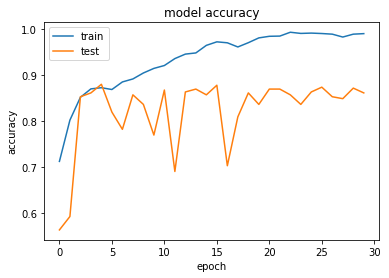

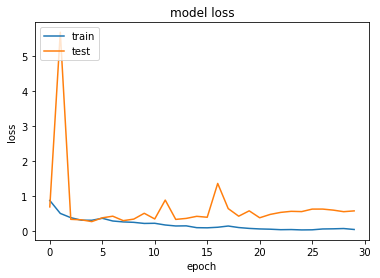

In [17]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save the weights for later use (optional)

In [18]:
#gmodel.save('weights.h5')

# predict the test.json 

In [19]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                        ], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

In [20]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)